In [1]:
# import libraries 
!pip install --upgrade setuptools
!pip install --upgrade pip
!pip install xgboost



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

  Attempting uninstall: pip

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\UALLAK~1\\AppData\\Local\\Temp\\pip-uninstall-xnkc395j\\pip.exe'
Consider using the `--user` option or check the permissions.




    Found existing installation: pip 20.3.1
    Uninstalling pip-20.3.1:
      Successfully uninstalled pip-20.3.1


In [2]:
#import datasets
df_train = pd.read_csv(r"C:\Users\uallakulov\ds_projects\capstone_houseprices\train.csv")
df_test = pd.read_csv(r"C:\Users\uallakulov\ds_projects\capstone_houseprices\test.csv")
ids = df_test['Id'].values

In [3]:
df_train.shape

(1460, 81)

In [4]:
df_test.shape

(1459, 80)

In [5]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [17]:
#let's have a look at data description
desc = open("data_description.txt", "r")
print(desc.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [7]:
def percent_missing(df):
    '''
    Calculates the percentage of missing values in a dataset.
    
    Args:
    inputs: Dataset
    returns: Dataset showing the percentage of missing values per column.
    '''
    percent_missing = df.isnull().sum()* 100/len(df)
    percent_missing_df = pd.DataFrame({'col': df.columns,
                                 'percent_missing': percent_missing})
    return percent_missing_df

In [8]:
missing_train = percent_missing(df_train)

In [9]:
missing_train["percent_missing"].sort_values(ascending = False).head(15)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageCond       5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
Name: percent_missing, dtype: float64

Most variables have less than 6% values missing. For this analysis, I will drop variables that have more than 20% values missing.

In [10]:
#select columns to remove
missing_remove = list(missing_train[missing_train["percent_missing"]>19]["col"])
missing_remove

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [11]:
train = df_train.drop(missing_remove, inplace = False, axis = 1)
test = df_test.drop(missing_remove, inplace = False, axis = 1)

In [12]:
train.shape, test.shape

((1460, 76), (1459, 75))

In [15]:
train['BsmtFinSF1']

0       706
1       978
2       486
3       216
4       655
       ... 
1455      0
1456    790
1457    275
1458     49
1459    830
Name: BsmtFinSF1, Length: 1460, dtype: int64

In [19]:
# engineer features using numeric attributes
def numeric_features(df):
    df['Total_indoor_area'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['Total_area'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] + df['GrLivArea'] + df['GarageArea']

    df['Total_bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                             df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    df['Total_baths'] = df['FullBath'] + 0.5 * df['HalfBath']

    df['Total_lot_area'] = df['LotFrontage'] + df['LotArea']
    df['Total_porch_area'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['ScreenPorch']


    df['Total_finished_basement'] = df['BsmtFinSF1'] + df['BsmtFinSF2']

    df['Total_porch_area'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                            df['EnclosedPorch'] + df['ScreenPorch'] +
                            df['WoodDeckSF'])
    
    # create dummies based on numeric features
    df['Pool_dummy'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['2floor_dummy'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['Garage_dummy'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['Basement_dummy'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['Fireplace_dummy'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    return df
    

In [20]:
train = numeric_features(train)
test = numeric_features(test)

In [21]:
train.shape, test.shape

((1460, 88), (1459, 87))

## Deal with categorical attributes

In [22]:
# list of categorical variables
categorical_col = ["MSSubClass","MSZoning", "Street", "LotShape", "LandContour", 
                   "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1",
                   "Condition2", "BldgType", "HouseStyle", "RoofStyle", "Exterior1st",
                   "Exterior2nd", "MasVnrType", "Foundation", "Heating", "Electrical", 
                   "GarageType", "SaleType", "SaleCondition", "CentralAir", "RoofMatl"]

In [38]:
#for col in categorical_col:
    #print(train[col].value_counts())

In [40]:
# clean NAs in categorical attributes
def categorical_na(df):
    for col in categorical_col:
        df[col] = df[col].replace("NA", np.nan)
    
    return df

In [42]:
train = categorical_na(train)

In [41]:
test = categorical_na(test)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

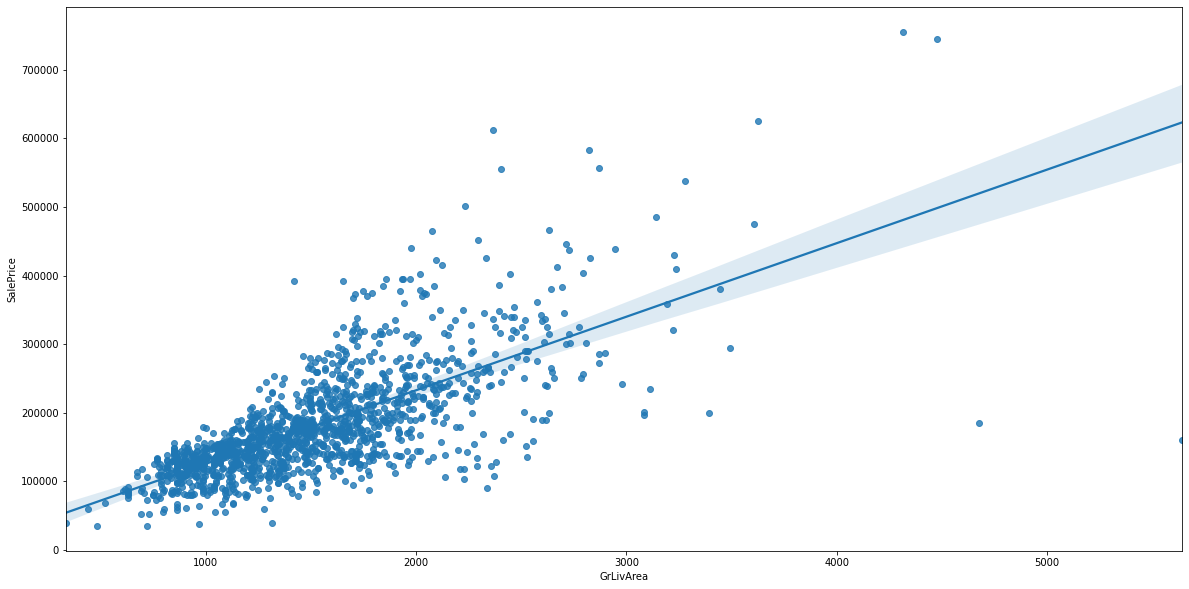

In [69]:
# check for outliers


plt.figure(figsize=(20,10))
sns.regplot(x=train['GrLivArea'], y=train['SalePrice'])

In [72]:
# capture four outliers
outliers = np.where(train['GrLivArea'] > 4000)[0]
outliers

array([ 523,  691, 1182, 1298], dtype=int64)

In [74]:
#drop the outliers from the train set
train = train.drop(train.index[outliers])

Next, I will create dummy variables using the categorical attributes. To do that, I first concatenatate the train and test datasets. This will ensure that the resulting new columns will be created using the categories in both datasets. Next, I split the concatenated datasets back to training and test sets. 

In [75]:
#drop the id column and save with the training and test datasets with different names
x_train = train.drop("Id", axis = 1, inplace = False)
df_test = test.drop("Id", axis = 1, inplace = False)

In [76]:
x_train.shape, df_test.shape

((1456, 87), (1459, 86))

In [77]:
#compare the columns
list(set(x_train.columns) - set(df_test.columns))

['SalePrice']

In [78]:
# keep the price column separately and drop it from the train dataset
SalePrice = x_train['SalePrice']
x_train.drop('SalePrice', inplace = True, axis = 1) 

In [79]:
#now we should have equal number of columns
x_train.shape, df_test.shape

((1456, 86), (1459, 86))

In [80]:
#length of the train set - I will needed to separate the concatenated set later
train_objs_num = len(x_train)

In [81]:
#concatenate the test and train sets
dataset = pd.concat(objs = [x_train, df_test], axis=0)

In [82]:
# get dummies on the combined data first
dataset_preprocessed  = pd.get_dummies(dataset, columns = categorical_col, prefix = categorical_col, dummy_na = False, drop_first = True)

In [83]:
# separate the test and train sets from the combined dataset
x_train = dataset_preprocessed[:train_objs_num]
df_test = dataset_preprocessed[train_objs_num:]

In [84]:
x_train.shape, df_test.shape

((1456, 220), (1459, 220))

## Deal with ordinal attributes

In [85]:
# list of variables to be treated as ordinal
ordinal_col = ["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", 
               "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", 
               "Functional", "GarageFinish", "GarageQual", "GarageCond", 
               "PavedDrive"]

In [86]:
x_train[ordinal_col].head()

,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
0,7,5,Gd,TA,Gd,TA,No,GLQ,Unf,Ex,Gd,Typ,RFn,TA,TA,Y
1,6,8,TA,TA,Gd,TA,Gd,ALQ,Unf,Ex,TA,Typ,RFn,TA,TA,Y
2,7,5,Gd,TA,Gd,TA,Mn,GLQ,Unf,Ex,Gd,Typ,RFn,TA,TA,Y
3,7,5,TA,TA,TA,Gd,No,ALQ,Unf,Gd,Gd,Typ,Unf,TA,TA,Y
4,8,5,Gd,TA,Gd,TA,Av,GLQ,Unf,Ex,Gd,Typ,RFn,TA,TA,Y


In [87]:
x_train.isnull().sum()

LotFrontage         259
LotArea               0
OverallQual           0
OverallCond           0
YearBuilt             0
                   ... 
RoofMatl_Metal        0
RoofMatl_Roll         0
RoofMatl_Tar&Grv      0
RoofMatl_WdShake      0
RoofMatl_WdShngl      0
Length: 220, dtype: int64

In [88]:
# impute before to be able to use and encoders on the ordinal attributes
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

#impute the train dataset
imputed_train=pd.DataFrame(imputer.fit_transform(x_train))
imputed_train.columns=x_train.columns
imputed_train.index=x_train.index

#impute the test dataset
imputed_test=pd.DataFrame(imputer.fit_transform(df_test))
imputed_test.columns=df_test.columns
imputed_test.index=df_test.index

In [89]:
imputed_train.shape, imputed_test.shape

((1456, 220), (1459, 220))

In [90]:
imputed_train.isnull().sum()

LotFrontage         0
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
                   ..
RoofMatl_Metal      0
RoofMatl_Roll       0
RoofMatl_Tar&Grv    0
RoofMatl_WdShake    0
RoofMatl_WdShngl    0
Length: 220, dtype: int64

In [91]:
#make sure no strings exist
#x_train.loc[:, x_train.dtypes == object]

In [92]:
#ordinal_col = ["BsmtCond", 
#               "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", 
#               "Functional", "GarageFinish", "GarageQual", "GarageCond", 
 #              "PavedDrive"]

In [93]:
#"OverallQual", "OverallCond", "ExterQual", "ExterCond","BsmtQual",

In [94]:
# Use label encoder on the ordinal attibutes
from sklearn.preprocessing import LabelEncoder

# make an encoder object
encoder = LabelEncoder()

# similar to the categorical variables, concatenate the two datasets to have the same set of categories
for col in ordinal_col:
    encoder.fit(pd.concat([imputed_train[col], imputed_test[col]], axis=0, sort=False))
    #apply the categories separately to the train and test sets
    imputed_train[col] = encoder.transform(imputed_train[col])
    imputed_test[col] = encoder.transform(imputed_test[col])

print('Train data shape is {}'.format(imputed_train.shape))
print('Test data shape is {}'.format(imputed_test.shape))

Train data shape is (1456, 220)
Test data shape is (1459, 220)


## Prepare datasets for ML

In [95]:
# convert all columns to float
X = imputed_train.astype(float)

# targets 
y = train.SalePrice.values

# set for Kaggle prediction
X_test = imputed_test.astype(float)

# iterative imputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
iter_imp = IterativeImputer(max_iter=10, random_state=0)

iter_train=pd.DataFrame(iter_imp.fit_transform(x_train))
iter_train.columns=x_train.columns
iter_train.index=x_train.index

# ML models

In [64]:
%cd "C:\Users\uallakulov\ds_projects\capstone_houseprices"

C:\Users\uallakulov\ds_projects\capstone_houseprices


In [183]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor
import xgboost as xgb

# XGBRegressor

pipeline1 = Pipeline([
        ('scaler', MinMaxScaler()),         
        ('XGB', XGBRegressor())
    ])
    
parameters1 = {
        'XGB__random_state': [10],
        'XGB__eta': [0.03, 0.04, 0.05], 
        'XGB__max_depth': [2, 3, 4, 8],
        'XGB__n_estimators': [1000, 1100, 1200],
        'XGB__learning_rate': [0.03, 0.05],
        'XGB__min_child_weight': [4, 5, 6],
        'XGB__subsample': [0.5, 0.6, 0.8],
        'XGB__colsample_bytree': [0.7, 0.9],
        'XGB__early_stopping_rounds': [10]
    }

# grid search with negative rmse scoring 
gs_xgb_rmse = GridSearchCV(pipeline1, param_grid = parameters1, n_jobs = 5, cv = 5, scoring = 'neg_root_mean_squared_error', verbose=True)

# grid search with mse scoring
gs_xgb_mae = GridSearchCV(pipeline1, param_grid = parameters1, n_jobs = 5, cv = 5, scoring = 'neg_mean_absolute_error', verbose=True)

In [134]:
gs_xgb_rmse.fit(X, y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   26.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.8min
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:  8.2min finished


[23:26:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('XGB',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                               

In [135]:
gs_xgb_rmse.best_score_ 

-20982.35874996016

In [145]:
gs_xgb_rmse.best_params_

{'XGB__colsample_bytree': 0.7,
 'XGB__early_stopping_rounds': 10,
 'XGB__eta': 0.04,
 'XGB__learning_rate': 0.05,
 'XGB__max_depth': 3,
 'XGB__min_child_weight': 5,
 'XGB__n_estimators': 300,
 'XGB__random_state': 10,
 'XGB__subsample': 0.8}

In [136]:
pred_xgb_rmse = gs_xgb_rmse.predict(X_test)

In [137]:
submission_xgb_rmse = pd.DataFrame()
submission_xgb_rmse['Id'] = test['Id']
submission_xgb_rmse['SalePrice'] = pred_xgb_rmse
submission_xgb_rmse.to_csv('submission_xgb_rmse.csv', index=False)

In [184]:
gs_xgb_mae.fit(X, y)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  7.2min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 22.4min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 42.7min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed: 71.2min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 104.5min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 142.4min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 191.2min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 247.4min
[Parallel(n_jobs=5)]: Done 4990 tasks      | elapsed: 318.4min
[Parallel(n_jobs=5)]: Done 6040 tasks      | elapsed: 395.3min
[Parallel(n_jobs=5)]: Done 6480 out of 6480 | elapsed: 431.5min finished


[10:16:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('XGB',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                               

In [185]:
gs_xgb_mae.best_score_

-13353.045766013363

In [186]:
pred_xgb_mae = gs_xgb_mae.predict(X_test)

In [187]:
submission_xgb_mae = pd.DataFrame()
submission_xgb_mae['Id'] = test['Id']
submission_xgb_mae['SalePrice'] = pred_xgb_mae
submission_xgb_mae.to_csv('submission_xgb_mae.csv', index=False)

In [188]:
gs_xgb_mae.best_params_

{'XGB__colsample_bytree': 0.7,
 'XGB__early_stopping_rounds': 10,
 'XGB__eta': 0.03,
 'XGB__learning_rate': 0.03,
 'XGB__max_depth': 3,
 'XGB__min_child_weight': 4,
 'XGB__n_estimators': 1000,
 'XGB__random_state': 10,
 'XGB__subsample': 0.5}

In [189]:
gs_xgb_mae.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('XGB',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7, early_stopping_rounds=10,
                              eta=0.03, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.03,
                              max_delta_step=0, max_depth=3, min_child_weight=4,
                              missing=nan, monotone_constraints='()',
                              n_estimators=1000, n_jobs=8, num_parallel_tree=1,
                              random_state=10, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.5,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [165]:
 gs_xgb_mse.fit(X, y)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


KeyboardInterrupt: 

In [117]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline_gbr = Pipeline([
        ('scaler', MinMaxScaler()),
        ('GFR', GradientBoostingRegressor())
    ])
    
parameters_gbr = {
        'GFR__learning_rate': [0.1, 0.2],
        'GFR__random_state': [10],
        'GFR__max_depth': [3, 4],
        'GFR__n_estimators': [500, 1000],
        'GFR__subsample': [0.5, 1],
        'GFR__criterion': ["friedman_mse", "mse", "mae"], 
        'GFR__tol': [0.01],
        'GFR__n_iter_no_change': [10]
    }

gs_gbr = GridSearchCV(pipeline_gbr, param_grid = parameters_gbr, n_jobs = 10, scoring='neg_root_mean_squared_error', cv = 5, verbose=True)

In [118]:
gs_gbr.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   14.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  3.9min
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed: 12.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robust-scaler', RobustScaler()),
                                       ('GFR', GradientBoostingRegressor())]),
             n_jobs=10,
             param_grid={'GFR__criterion': ['friedman_mse', 'mse', 'mae'],
                         'GFR__learning_rate': [0.1, 0.2],
                         'GFR__max_depth': [3, 4],
                         'GFR__n_estimators': [100, 200],
                         'GFR__n_iter_no_change': [10],
                         'GFR__random_state': [10], 'GFR__subsample': [0.5, 1],
                         'GFR__tol': [0.01]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [119]:
gs_gbr.best_score_

-22420.42746697993

In [120]:
gs_gbr.best_params_

{'GFR__criterion': 'friedman_mse',
 'GFR__learning_rate': 0.1,
 'GFR__max_depth': 3,
 'GFR__n_estimators': 200,
 'GFR__n_iter_no_change': 10,
 'GFR__random_state': 10,
 'GFR__subsample': 0.5,
 'GFR__tol': 0.01}

In [122]:
pred_gbr = gs_gbr.predict(X_test)

In [123]:
submission_gbr = pd.DataFrame()
submission_gbr['Id'] = test['Id']
submission_gbr['SalePrice'] = pred_gbr
submission_gbr.to_csv('submission_gbr.csv', index=False)

In [203]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

pipeline_gbr = Pipeline([
        ('scaler', MinMaxScaler()),
        ('GFR', GradientBoostingRegressor())
    ])
    
parameters_gbr = {
        'GFR__learning_rate': [0.1, 0.2],
        'GFR__random_state': [10],
        'GFR__max_depth': [3, 4],
        'GFR__n_estimators': [200, 220],
        'GFR__subsample': [0.5, 1],
        'GFR__criterion': ["friedman_mse", "mse", "mae"], 
        'GFR__tol': [0.01],
        'GFR__n_iter_no_change': [10]
    }

gs_gbr = GridSearchCV(pipeline_gbr, param_grid = parameters_gbr, n_jobs = 10, scoring='neg_mean_absolute_error', cv = 5, verbose=True)

In [125]:
gs_gbr.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed: 11.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('GFR', GradientBoostingRegressor())]),
             n_jobs=10,
             param_grid={'GFR__criterion': ['friedman_mse', 'mse', 'mae'],
                         'GFR__learning_rate': [0.1, 0.2],
                         'GFR__max_depth': [3, 4],
                         'GFR__n_estimators': [200, 220],
                         'GFR__n_iter_no_change': [10],
                         'GFR__random_state': [10], 'GFR__subsample': [0.5, 1],
                         'GFR__tol': [0.01]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [126]:
gs_gbr.best_score_

-21915.027238646

In [127]:
pred_gbr = gs_gbr.predict(X_test)

In [128]:
submission_gbr = pd.DataFrame()
submission_gbr['Id'] = test['Id']
submission_gbr['SalePrice'] = pred_gbr
submission_gbr.to_csv('submission_gbr2.csv', index=False)